In [1]:
import torch
from load_data import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda:0')

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_compas_data(random_state=42)
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

In [5]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.34085958]
training default:  [0.5214894]
test default:  [0.51270208]
# training samples: (5049, 7)
# test samples: (2165, 7)
# sensitive vars (5049, 1)
# output vars (5049, 1)


In [6]:
Xrs = np.row_stack([Xtr,Xte])
print(Xrs.shape)
print(np.unique(Xrs,axis=0).shape)

(7214, 7)
(7214, 7)


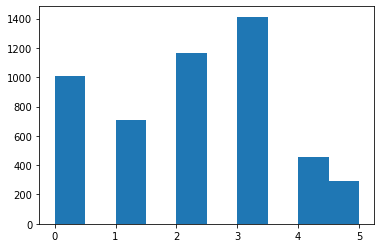

In [7]:
import matplotlib.pyplot as plt
yz_tr = ytr+Ztr*2
plt.hist(yz_tr)
plt.show()

In [10]:
N1 = 5000
Xtr1, ytr1, Ztr1, Xtr2, ytr2, Ztr2 = split_initial_dataset(Xtr,ytr,Ztr,N_init=N1,random_state=42)

In [11]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.34085958]
training init:  [0.52]
select init:  [0.67346939]
test default:  [0.51270208]


In [12]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [13]:
class Args:
    def __init__(self):
        self.epochs = 20
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [14]:
from fairAL_utils import *

In [15]:
args = Args()
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [16]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
liveloss = PlotLosses()

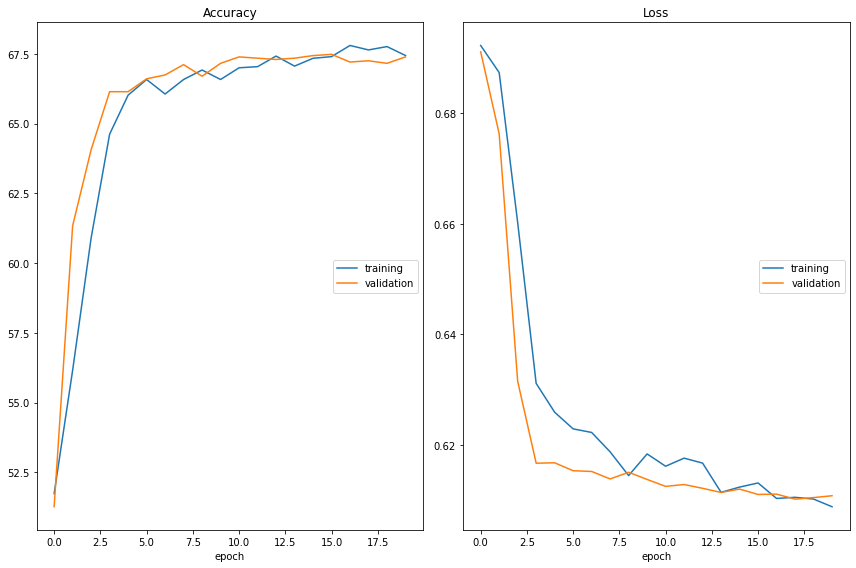

Accuracy
	training         	 (min:   51.740, max:   67.800, cur:   67.440)
	validation       	 (min:   51.270, max:   67.483, cur:   67.390)
Loss
	training         	 (min:    0.609, max:    0.692, cur:    0.609)
	validation       	 (min:    0.610, max:    0.691, cur:    0.611)
Finished Training


In [51]:
train_model(clf, train_loader, clf_criterion,clf_optimizer, device, args.epochs, test_loader,liveloss)
torch.save(clf.state_dict(),"../results/compas/AL_iter_2.ckpt") # 모든 애들을 다 0으로 예측함

In [15]:
clf.load_state_dict(torch.load("../results/compas/AL_iter_2.ckpt"))

<All keys matched successfully>

# Visualize the trained model

In [52]:
clf.eval()
from torchsummary import summary
summary(clf.to('cuda:0'),(7,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             256
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total

In [53]:
param_names = ['lin1_w','lin1_b','lin2_w',' lin2_b','lin3_w','lin3_b','lin4_w','lin4_b']

# instance-level gradient

In [54]:
from viz_utils import *

In [55]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [56]:
import numpy as np
import torch.nn as nn

class LogitSum(nn.Module):
    def __init__(self,reduce=True):
        super(LogitSum,self).__init__()
        self.reduce=reduce
    def forward(self,output):
        loss = output
        if self.reduce:
            return loss.sum()
        else:
            return loss

In [57]:
bn_criterion = BinaryEntropy()
lg_criterion = LogitSum()

In [58]:
out_tr, y_tr, z_tr, wgrad_tr, grdic_tr = compute_grad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te, y_te, z_te, wgrad_te, grdic_te = compute_grad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [59]:
out_tr2, y_tr2, z_tr2, wgrad_tr2, grdic_tr2 = compute_predgrad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te2, y_te2, z_te2, wgrad_te2, grdic_te2 = compute_predgrad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [60]:
out_tr3, y_tr3, z_tr3, wgrad_tr3, grdic_tr3 = compute_predgrad_arrs(clf, train_loader, bn_criterion, device, param_names,True)
out_te3, y_te3, z_te3, wgrad_te3, grdic_te3 = compute_predgrad_arrs(clf, test_loader, bn_criterion, device, param_names,True)

In [61]:
out_tr4, y_tr4, z_tr4, wgrad_tr4, grdic_tr4 = compute_predgrad_arrs(clf, train_loader, lg_criterion, device, param_names,True)
out_te4, y_te4, z_te4, wgrad_te4, grdic_te4 = compute_predgrad_arrs(clf, test_loader, lg_criterion, device, param_names,True)

In [78]:
print(calculate_overall_accuracy(out_te4,y_te4))
print("z=0: ",calculate_overall_accuracy(out_te4[z_te4==0],y_te4[z_te4==0]))
print("z=1: ",calculate_overall_accuracy(out_te4[z_te4==1],y_te4[z_te4==1]))
print("z=2: ",calculate_overall_accuracy(out_te4[z_te4==2],y_te4[z_te4==2]))

0.6739030023094689
z=0:  0.6412005457025921
z=1:  0.6863799283154122
z=2:  0.7056962025316456


In [79]:
print(calculate_overall_accuracy(out_tr4,y_tr4))
print("z=0: ",calculate_overall_accuracy(out_tr4[z_tr4==0],y_tr4[z_tr4==0]))
print("z=1: ",calculate_overall_accuracy(out_tr4[z_tr4==1],y_tr4[z_tr4==1]))
print("z=2: ",calculate_overall_accuracy(out_tr4[z_tr4==2],y_tr4[z_tr4==2]))

0.682
z=0:  0.6760233918128655
z=1:  0.6821036106750392
z=2:  0.6954177897574124


In [62]:
wgrad_tr4.shape

(5000, 2401)

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
def corr_grad(grad_arr,y,z):
    mgrad = np.mean(grad_arr,axis=0)
    mgrad_y0 = np.mean(grad_arr[y==0],axis=0)
    mgrad_y1 = np.mean(grad_arr[y==1],axis=0)
    mgrad_z0 = np.mean(grad_arr[z==0],axis=0)
    mgrad_z1 = np.mean(grad_arr[z==1],axis=0)
    mgrad_z2 = np.mean(grad_arr[z==2],axis=0)
    aa = [mgrad,mgrad_y0,mgrad_y1,mgrad_z0,mgrad_z1,mgrad_z2]
    for a in aa:
        print(np.linalg.norm(a))
    aan = np.row_stack(aa)
    print(cosine_similarity(aan,aan))

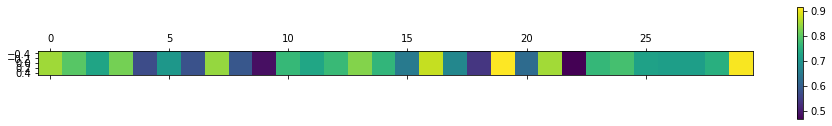

In [64]:
st_idx = 0
ds_idx = 30
sim_mat4 = cosine_similarity(np.expand_dims(np.mean(wgrad_te4,axis=0),axis=0), wgrad_te4)
plt.matshow(sim_mat4[:,st_idx:ds_idx])
plt.colorbar()

In [82]:
sim_mat41 = cosine_similarity(np.expand_dims(np.mean(wgrad_te4[z_te==0],axis=0),axis=0), wgrad_te4)
sim_mat42 = cosine_similarity(np.expand_dims(np.mean(wgrad_te4[z_te==1],axis=0),axis=0), wgrad_te4)
sim_mat43 = cosine_similarity(np.expand_dims(np.mean(wgrad_te4[z_te==2],axis=0),axis=0), wgrad_te4)

In [69]:
print(np.sum(np.dot(np.expand_dims(np.mean(wgrad_te4,axis=0),axis=0),wgrad_te4.T)<0))

0


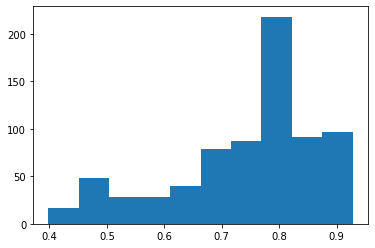

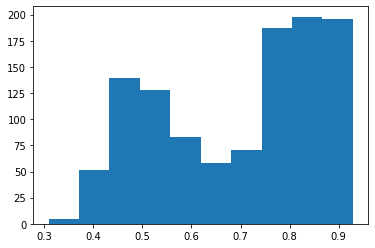

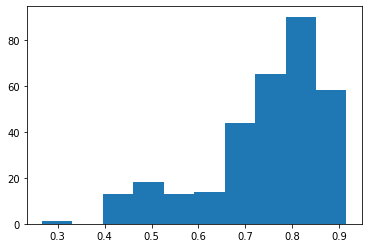

In [83]:
plt.hist(sim_mat41[0][z_te==0])
plt.show()
plt.hist(sim_mat41[0][z_te==1])
plt.show()
plt.hist(sim_mat41[0][z_te==2])
plt.show()

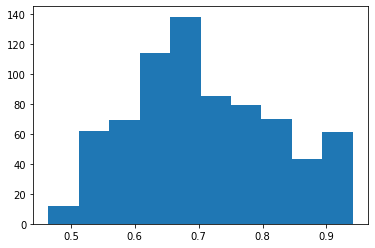

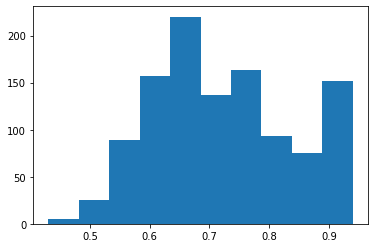

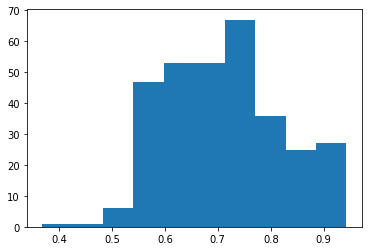

In [84]:
plt.hist(sim_mat42[0][z_te==0])
plt.show()
plt.hist(sim_mat42[0][z_te==1])
plt.show()
plt.hist(sim_mat42[0][z_te==2])
plt.show()

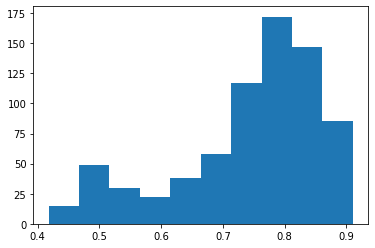

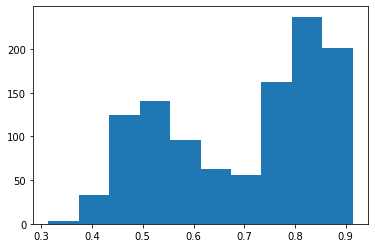

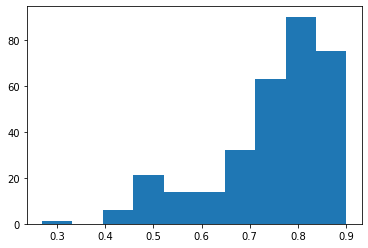

In [85]:
plt.hist(sim_mat43[0][z_te==0])
plt.show()
plt.hist(sim_mat43[0][z_te==1])
plt.show()
plt.hist(sim_mat43[0][z_te==2])
plt.show()

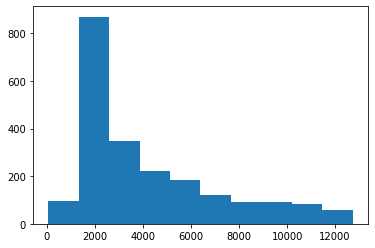

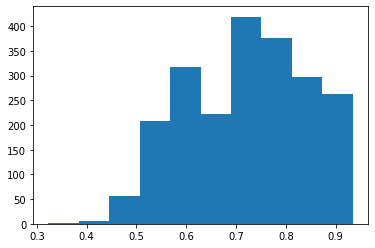

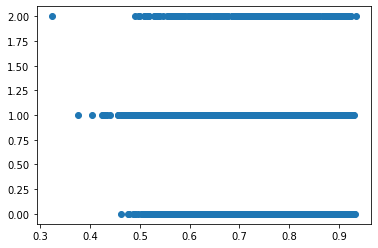

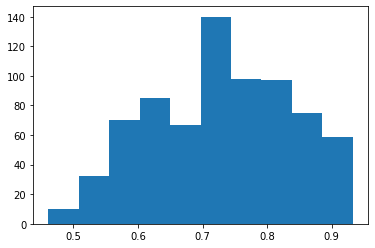

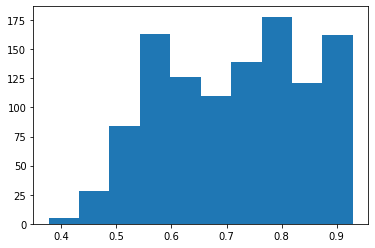

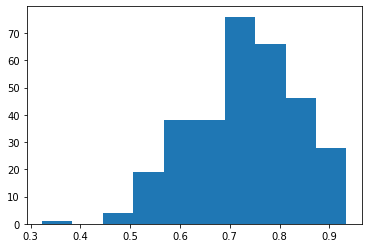

In [81]:
plt.hist(np.dot(np.expand_dims(np.mean(wgrad_te4,axis=0),axis=0),wgrad_te4.T).ravel())
plt.show()
plt.hist(sim_mat4[0])
plt.show()
plt.scatter(sim_mat4[0],z_te)
plt.show()
plt.hist(sim_mat4[0][z_te==0])
plt.show()
plt.hist(sim_mat4[0][z_te==1])
plt.show()
plt.hist(sim_mat4[0][z_te==2])
plt.show()

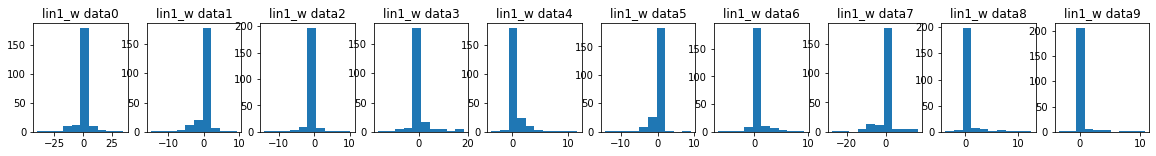

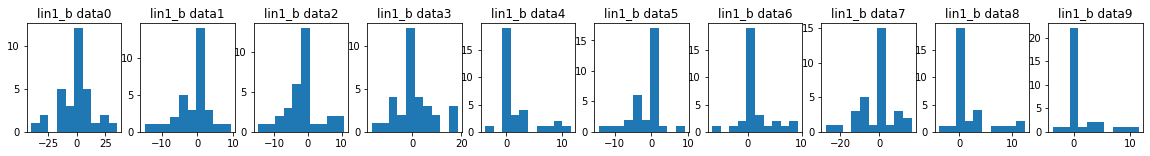

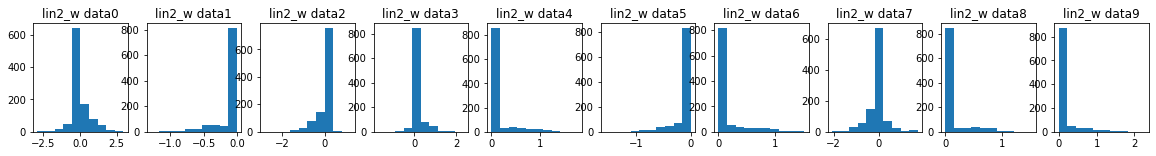

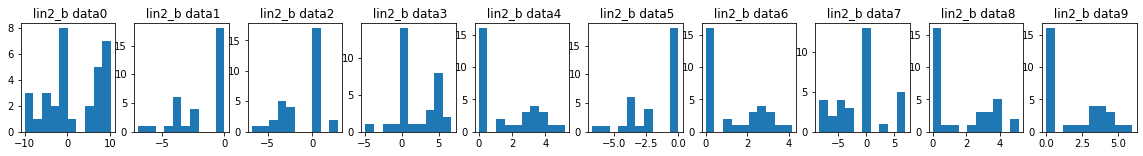

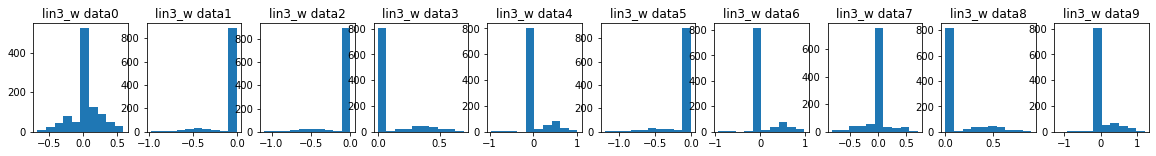

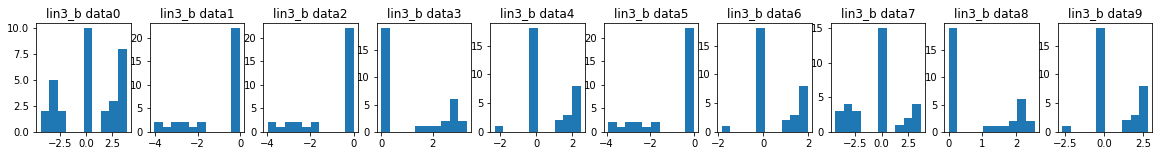

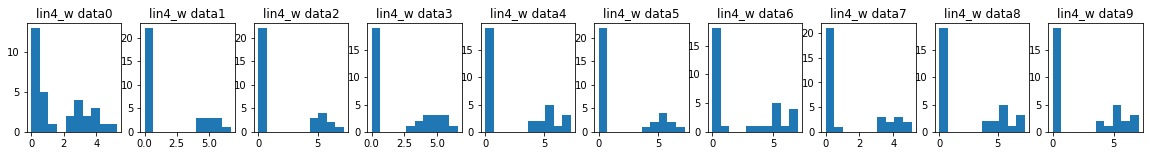

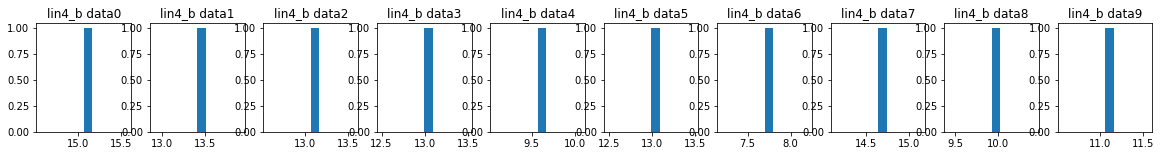

In [86]:
st_idx = 0
ds_idx = 10
for k in grdic_te4:
    fig,axs = plt.subplots(1,ds_idx,figsize=(20,2))
    for j in range(ds_idx):
        axs[j].hist(grdic_te4[k][j])
        axs[j].set_title(k+' data'+str(j))
    plt.show()

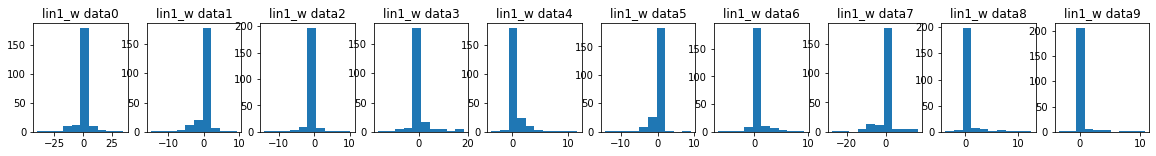

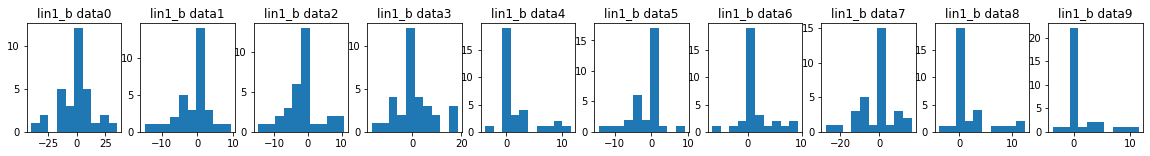

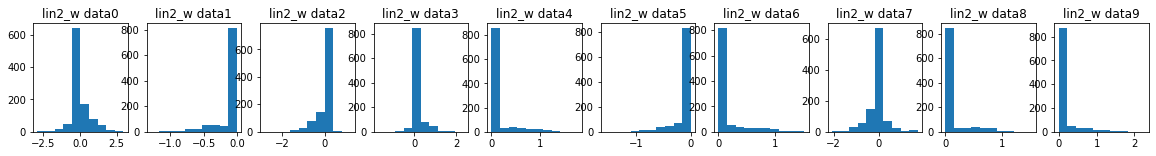

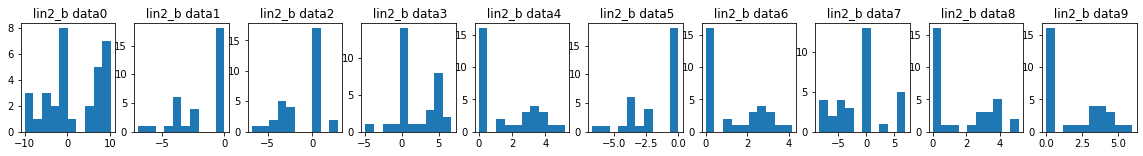

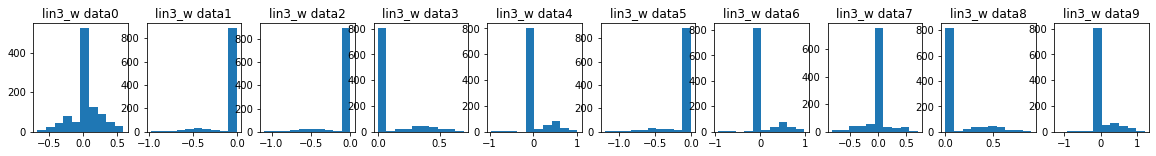

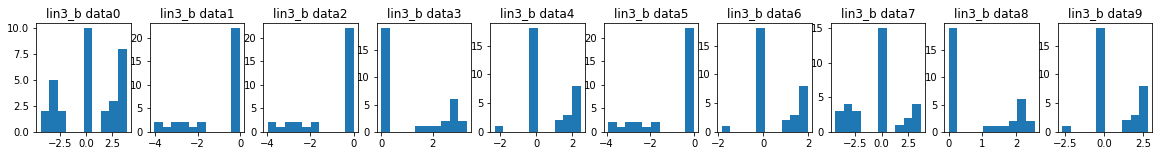

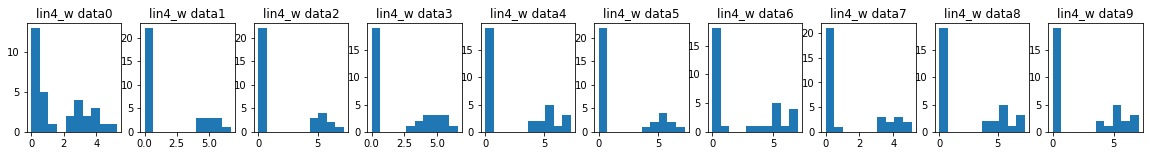

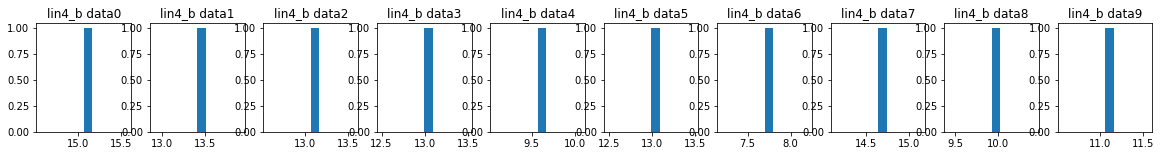

In [65]:
st_idx = 0
ds_idx = 10
for k in grdic_te4:
    fig,axs = plt.subplots(1,ds_idx,figsize=(20,2))
    for j in range(ds_idx):
        axs[j].hist(grdic_te4[k][j])
        axs[j].set_title(k+' data'+str(j))
    plt.show()

In [86]:
print(sim_matp.shape)
print(sim_marp.shape)

(13564, 13564)
(1, 1)


In [91]:
np.unravel_index(np.argmax(sim_marp),sim_marp.shape)

(2761, 2761)

In [95]:
max(grdic_te4[param_names[-1]])

array([16.], dtype=float32)

In [109]:
# np.eye(wgrad_te4.shape[0]).shape
# print(wgrad_te4.shape[0])
print(np.ones((wgrad_te4.shape[0],wgrad_te4.shape[0])))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [35]:
mask_mat = np.ones((wgrad_te4.shape[0],wgrad_te4.shape[0])) - np.eye(wgrad_te4.shape[0])

In [36]:
print(mask_mat)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


-0.00963861495256424 1.0 2342529.0


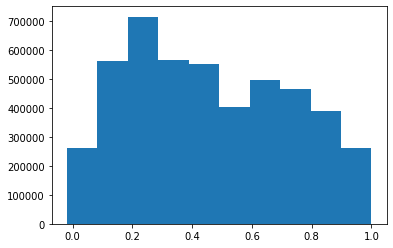

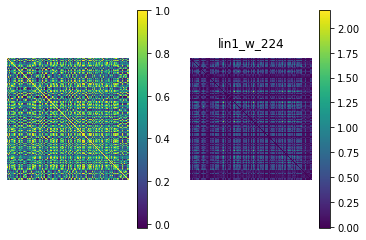

-0.020527370274066925 1.0 2342529.0


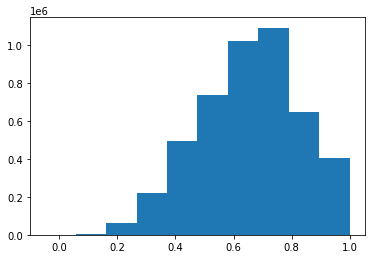

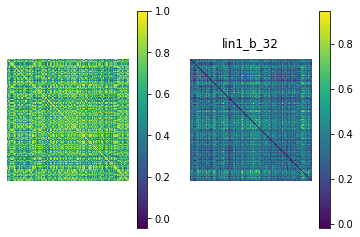

0.0 0.0 2342530.0


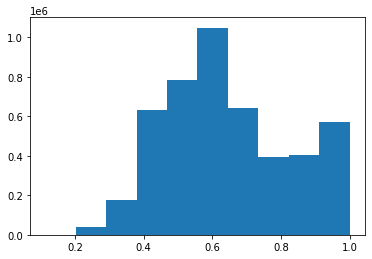

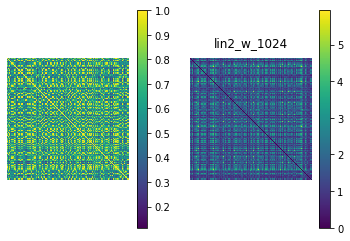

0.0 0.0 2342530.0


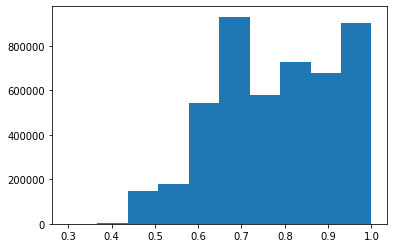

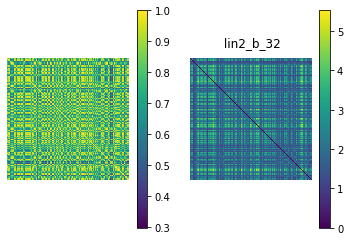

0.0 0.0 2342530.0


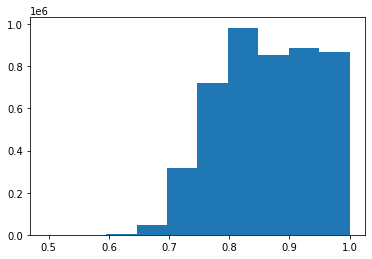

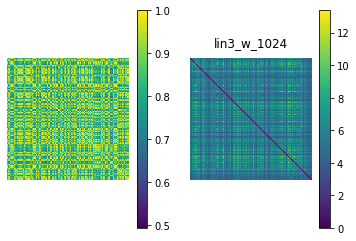

0.0 0.0 2342530.0


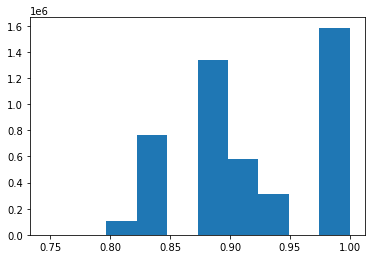

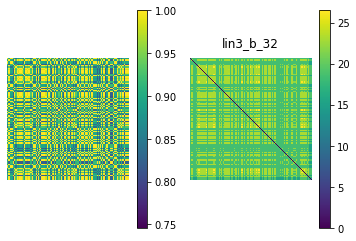

0.0 0.0 2342530.0


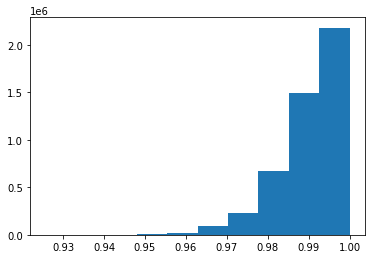

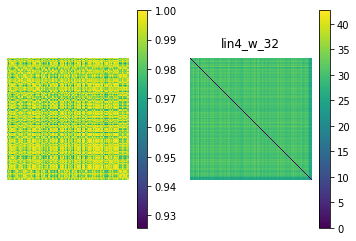

0.0 0.0 2342530.0


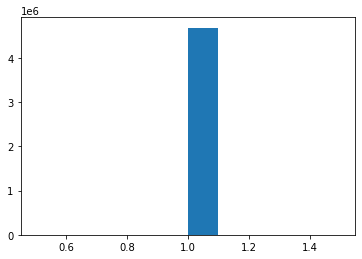

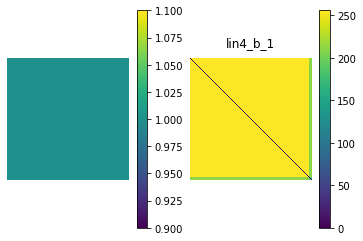

In [37]:

for k in grdic_te4:
    sim_matp = cosine_similarity(grdic_te4[k], grdic_te4[k])
    sim_marp = np.dot(grdic_te4[k], grdic_te4[k].T)
    sim_marp = sim_marp*mask_mat
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    plt.hist(sim_matp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

-6.198843002319336 48.0 4902.0


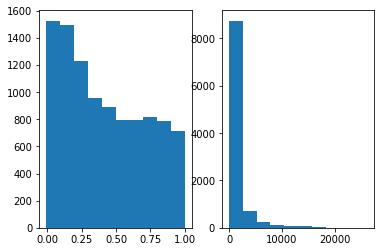

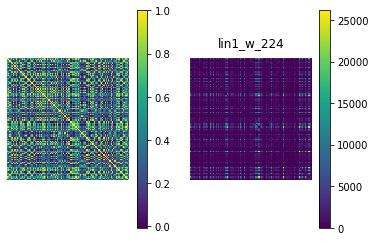

-5.412321090698242 48.0 4902.0


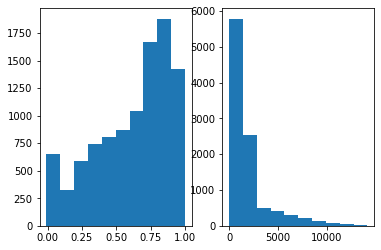

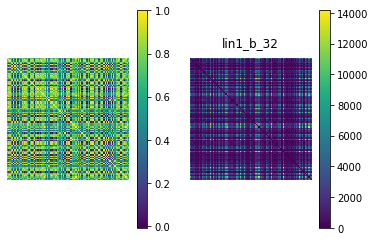

-1.2523293495178223 271.0 4659.0


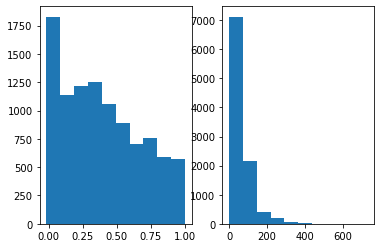

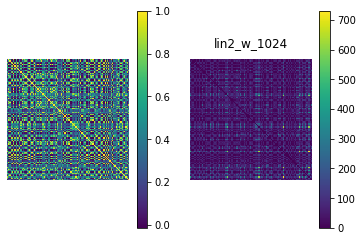

-9.740986824035645 271.0 4659.0


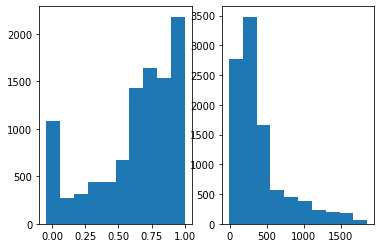

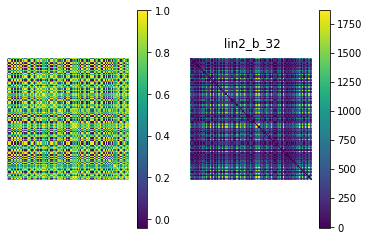

0.0 0.0 4467.0


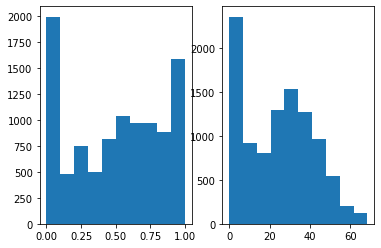

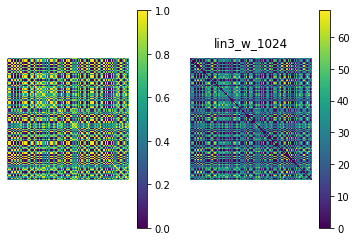

0.0 0.0 4467.0


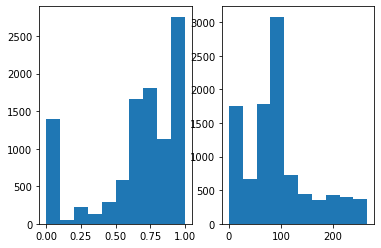

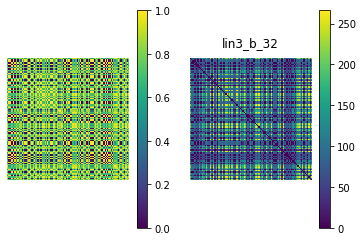

0.0 0.0 4467.0


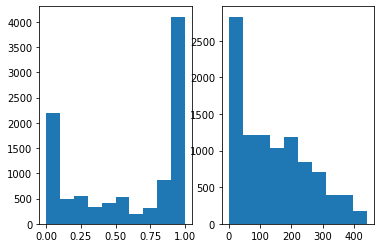

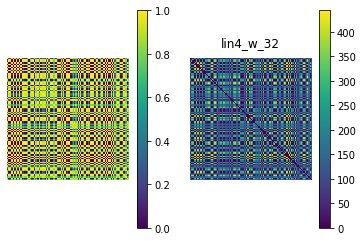

0.0 0.0 4950.0


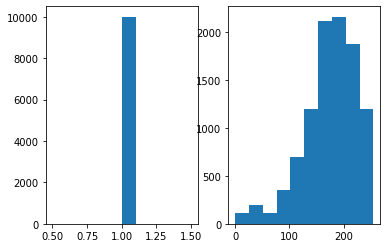

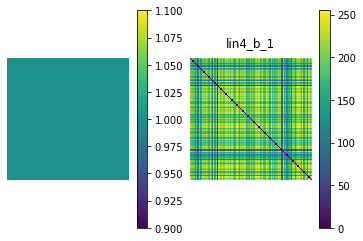

In [66]:
st_idx = 0
ds_idx = 100
for k in grdic_te4:
    sim_matp = cosine_similarity(grdic_te4[k][st_idx:ds_idx], grdic_te4[k][st_idx:ds_idx])
    sim_marp = np.dot(grdic_te4[k][st_idx:ds_idx], grdic_te4[k][st_idx:ds_idx].T)
    sim_marp = sim_marp*mask_mat[st_idx:ds_idx,st_idx:ds_idx]
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    fig,axs = plt.subplots(1,2)
    axs[0].hist(sim_matp.ravel())
    axs[1].hist(sim_marp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

-250.041748046875 11.0 4925.0


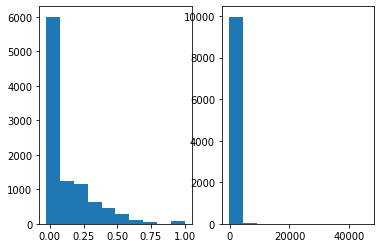

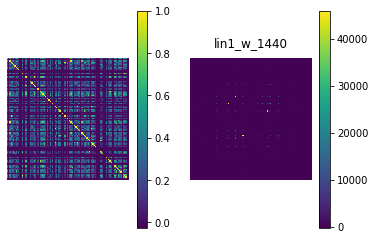

-114.30081939697266 11.0 4925.0


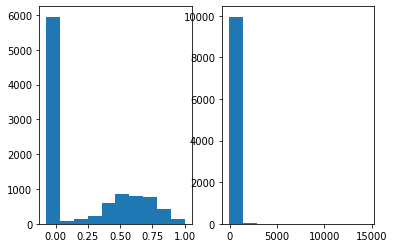

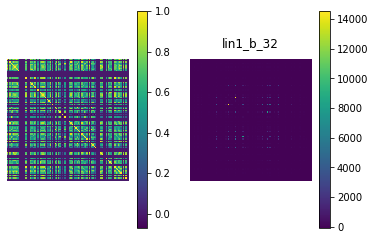

0.0 0.0 4936.0


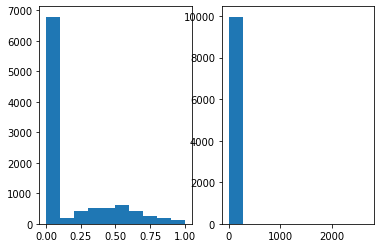

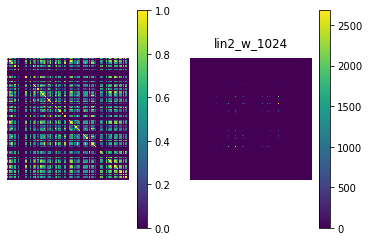

0.0 0.0 4950.0


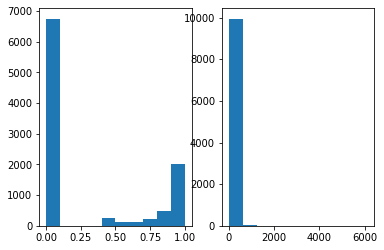

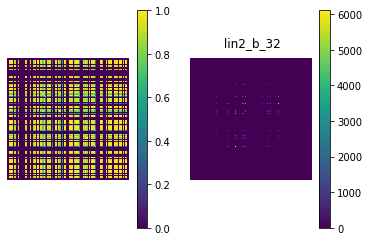

0.0 0.0 4950.0


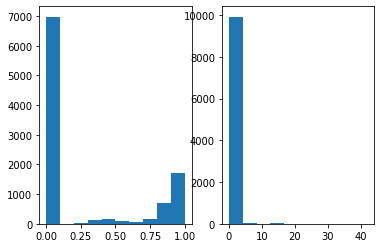

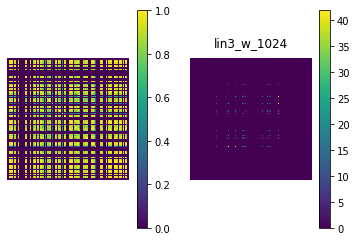

0.0 0.0 4950.0


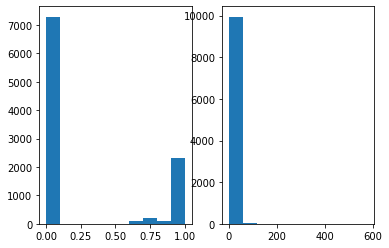

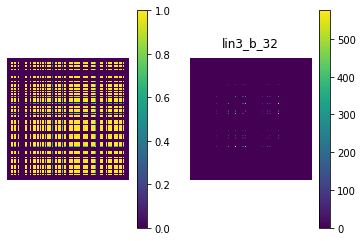

0.0 0.0 4950.0


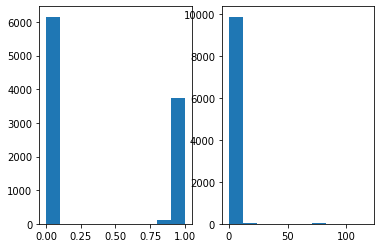

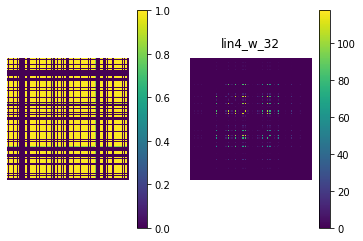

0.0 0.0 4950.0


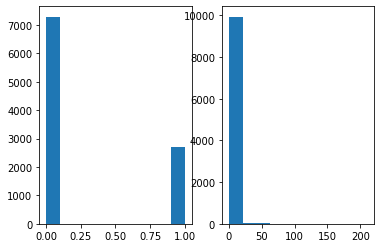

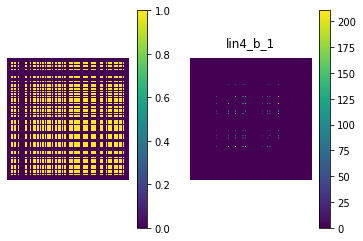

In [125]:
st_idx = 0
ds_idx = 100
for k in grdic_tr4:
    sim_matp = cosine_similarity(grdic_tr4[k][st_idx:ds_idx], grdic_tr4[k][st_idx:ds_idx])
    sim_marp = np.dot(grdic_tr4[k][st_idx:ds_idx], grdic_tr4[k][st_idx:ds_idx].T)
    sim_marp = sim_marp*mask_mat[st_idx:ds_idx,st_idx:ds_idx]
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    fig,axs = plt.subplots(1,2)
    axs[0].hist(sim_matp.ravel())
    axs[1].hist(sim_marp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

(2165, 2165)


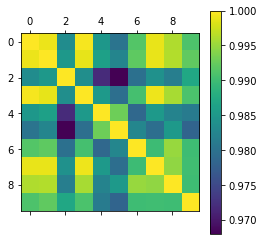

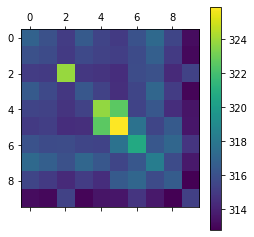

In [38]:
st_idx = 0
ds_idx = 10
sim_matt4 = cosine_similarity(wgrad_te4, wgrad_te4)
sim_mait4 = np.dot(wgrad_te4,wgrad_te4.T)
print(sim_mait4.shape)
plt.matshow(sim_matt4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.matshow(sim_mait4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()


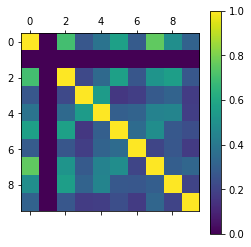

In [42]:
st_idx = 0
ds_idx = 10
sim_matr4 = cosine_similarity(wgrad_tr4, wgrad_tr4)
plt.matshow(sim_matr4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()

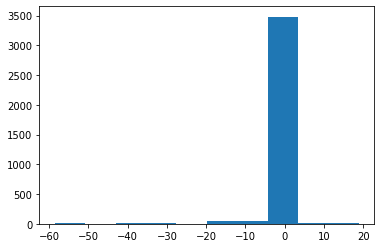

In [45]:
plt.hist(wgrad_tr4[31])
plt.show()

In [41]:
sim_matt4[:2,:10]

array([[9.9999988e-01, 3.0907422e-01, 2.8559230e-14, 1.9392102e-08,
        1.6986509e-01, 5.6058563e-10, 1.9573006e-01, 2.7705583e-12,
        9.3007807e-10, 1.5596244e-01],
       [3.0907422e-01, 9.9999988e-01, 2.9803220e-14, 5.5852134e-08,
        5.3299636e-01, 1.0706531e-09, 3.9451161e-01, 3.3561016e-12,
        2.1433821e-09, 2.7576339e-01]], dtype=float32)

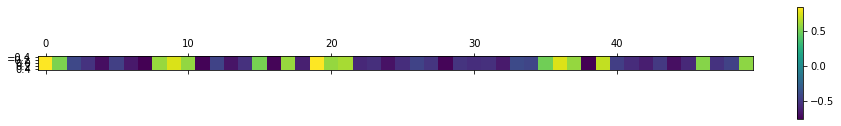

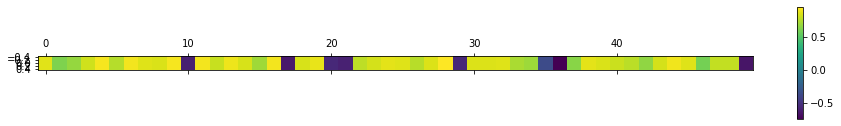

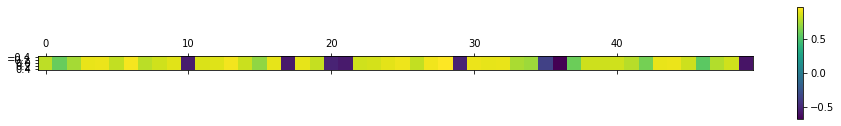

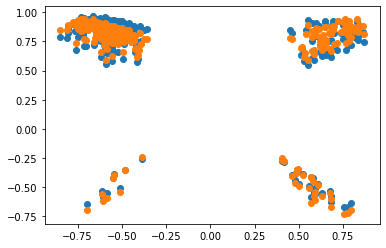

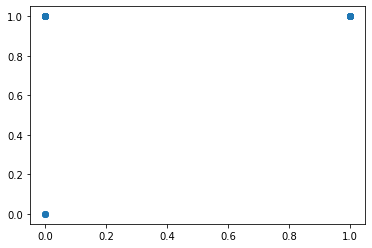

In [39]:
st_idx = 0
ds_idx = 50
sim_mat = cosine_similarity(np.expand_dims(np.mean(wgrad_te,axis=0),axis=0), wgrad_te)
plt.matshow(sim_mat[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat2 = cosine_similarity(np.expand_dims(np.mean(wgrad_te2,axis=0),axis=0), wgrad_te2)
plt.matshow(sim_mat2[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat3 = cosine_similarity(np.expand_dims(np.mean(wgrad_te3,axis=0),axis=0), wgrad_te3)
plt.matshow(sim_mat3[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
plt.scatter(sim_mat,sim_mat3)
plt.scatter(sim_mat,sim_mat2)
plt.show()
plt.scatter(y_tr[st_idx:ds_idx],out_tr[st_idx:ds_idx])
plt.show()

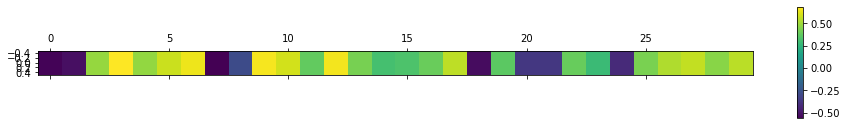

In [149]:
wgrad_tr.shape

(5000, 3617)

In [40]:
ngr = np.linalg.norm(wgrad_tr,axis=1)
ngr2 = np.linalg.norm(wgrad_tr2,axis=1)
ngr3 = np.linalg.norm(wgrad_tr3,axis=1)

In [41]:
ngrte = np.linalg.norm(wgrad_te,axis=1)
ngr2te = np.linalg.norm(wgrad_te2,axis=1)
ngr3te = np.linalg.norm(wgrad_te3,axis=1)

In [42]:
ngr.shape

(700,)

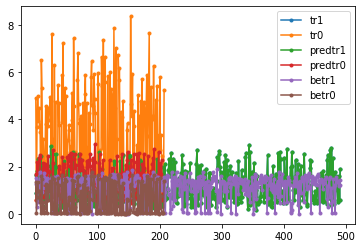

In [43]:
plt.plot(ngr[y_tr==1],marker='.',label='tr1')
plt.plot(ngr[y_tr==0],marker='.',label='tr0')
plt.plot(ngr2[y_tr==1],marker='.',label='predtr1')
plt.plot(ngr2[y_tr==0],marker='.',label='predtr0')
plt.plot(ngr3[y_tr==1],marker='.',label='betr1')
plt.plot(ngr3[y_tr==0],marker='.',label='betr0')
plt.legend()
plt.show()

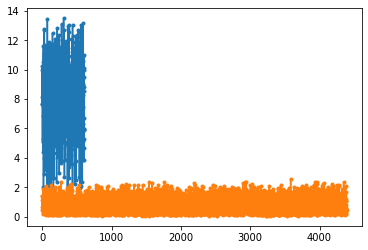

In [164]:
plt.plot(ngr[y_tr==1],marker='.')
plt.plot(ngr[y_tr==0],marker='.')
# plt.plot(ngr2[y_tr==1],marker='.')
# plt.plot(ngr2[y_tr==0],marker='.')
plt.show()

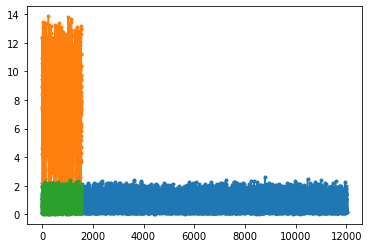

In [171]:
plt.plot(ngrte[y_te==0],marker='.')
plt.plot(ngrte[y_te==1],marker='.')
plt.plot(ngr2te[y_te==1],marker='.')
# plt.plot(ngr2te[y_te==0],marker='.')
plt.show()

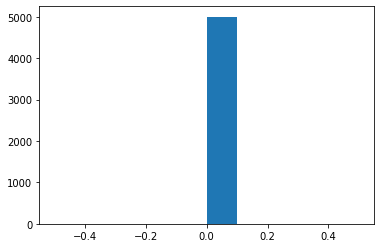

In [147]:
plt.hist(out_tr)
plt.show()

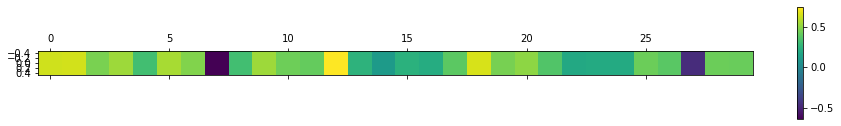

In [137]:
for i in range(30):
    print("-"*10,i,'-'*10)
    print(out_te[i],out_te2[i])
    print(y_te[i],y_te2[i])

---------- 0 ----------
0.0 0.0
0.0 0.0
---------- 1 ----------
0.0 0.0
0.0 0.0
---------- 2 ----------
0.0 0.0
0.0 0.0
---------- 3 ----------
0.0 0.0
0.0 0.0
---------- 4 ----------
0.0 0.0
0.0 0.0
---------- 5 ----------
0.0 0.0
0.0 0.0
---------- 6 ----------
0.0 0.0
0.0 0.0
---------- 7 ----------
0.0 0.0
0.0 0.0
---------- 8 ----------
0.0 0.0
0.0 0.0
---------- 9 ----------
0.0 0.0
1.0 1.0
---------- 10 ----------
0.0 0.0
0.0 0.0
---------- 11 ----------
0.0 0.0
0.0 0.0
---------- 12 ----------
0.0 0.0
0.0 0.0
---------- 13 ----------
0.0 0.0
0.0 0.0
---------- 14 ----------
0.0 0.0
0.0 0.0
---------- 15 ----------
0.0 0.0
0.0 0.0
---------- 16 ----------
0.0 0.0
0.0 0.0
---------- 17 ----------
0.0 0.0
0.0 0.0
---------- 18 ----------
0.0 0.0
0.0 0.0
---------- 19 ----------
0.0 0.0
0.0 0.0
---------- 20 ----------
0.0 0.0
0.0 0.0
---------- 21 ----------
0.0 0.0
1.0 1.0
---------- 22 ----------
0.0 0.0
0.0 0.0
---------- 23 ----------
0.0 0.0
1.0 1.0
---------- 24 ----------
0

In [124]:
sim_mat[20]

array([-0.43377766, -0.6402937 , -0.6737147 , ..., -0.40176624,
       -0.42649603, -0.49073365], dtype=float32)

In [49]:
corr_grad(wgrad_tr,y_tr,z_tr)
corr_grad(grdic_tr[param_names[4]],y_tr,z_tr)

0.12494504
2.672454
0.9646204
0.35256904
0.08055194
[[ 1.0000001   0.94002295 -0.9167206   0.9531899   0.9533583 ]
 [ 0.94002295  1.         -0.99802256  0.9356355   0.8566328 ]
 [-0.9167206  -0.99802256  0.9999999  -0.92020833 -0.827645  ]
 [ 0.9531899   0.9356355  -0.92020833  1.          0.8174625 ]
 [ 0.9533583   0.8566328  -0.827645    0.8174625   1.0000005 ]]
0.0151879005
0.47666842
0.1822464
0.04007395
0.0101318
[[ 1.          0.90282583 -0.87972754  0.96429706  0.9710466 ]
 [ 0.90282583  0.99999976 -0.9986991   0.8660585   0.88077545]
 [-0.87972754 -0.9986991   0.99999994 -0.8433052  -0.8587786 ]
 [ 0.96429706  0.8660585  -0.8433052   1.0000002   0.8731137 ]
 [ 0.9710466   0.88077545 -0.8587786   0.8731137   0.99999976]]


In [44]:
print(y_te.shape)

(2165,)


In [46]:
import numpy.linalg as la
print(np.mean(la.norm(wgrad_te,axis=1)))
print('-'*6)
corr_grad(wgrad_te,y_te,z_te)
for pr in param_names:
    print("="*3+pr+"="*3)
    print(np.mean(la.norm(grdic_te[pr],axis=1)))
    print("-"*6)
    corr_grad(grdic_te[pr],y_te,z_te)

0.56077063
------
0.014191302
0.55476695
0.5577779
0.07857965
0.06655689
[[ 0.9999999   0.89490134 -0.8842603   0.9221374  -0.84816736]
 [ 0.89490134  1.0000001  -0.9997285   0.9977467  -0.99528414]
 [-0.8842603  -0.9997285   1.         -0.9959485   0.9972336 ]
 [ 0.9221374   0.9977467  -0.9959485   1.         -0.98695767]
 [-0.84816736 -0.99528414  0.9972336  -0.98695767  1.        ]]
===lin1_w===
0.02201229
------
0.0012870654
0.015463862
0.01637692
0.0020975654
0.0024640823
[[ 0.9999999   0.04056795  0.12097424  0.48368105  0.5404521 ]
 [ 0.04056795  0.99999994 -0.9869309   0.8837139  -0.80796194]
 [ 0.12097424 -0.9869309   0.99999994 -0.79993963  0.8898516 ]
 [ 0.48368105  0.8837139  -0.79993963  1.0000001  -0.46546006]
 [ 0.5404521  -0.80796194  0.8898516  -0.46546006  0.9999998 ]]
===lin1_b===
0.022672454
------
0.0011471917
0.018705912
0.018182717
0.0028564197
0.002015771
[[ 1.          0.6720564  -0.5979646   0.8245497  -0.27610344]
 [ 0.6720564   1.0000002  -0.99539334  0.9688

In [67]:
import numpy.linalg as la
print(np.mean(la.norm(wgrad_te,axis=1)))
print('-'*6)
corr_grad(wgrad_te,y_te,z_te)
for pr in param_names:
    print("="*3+pr+"="*3)
    print(np.mean(la.norm(grdic_te[pr],axis=1)))
    print("-"*6)
    corr_grad(grdic_te[pr],y_te,z_te)

2.6138742
------
0.14696048
2.1171162
1.9391358
0.18406644
0.10610739
0.2941585
[[ 1.0000007   0.96193784 -0.949455    0.911289    0.94001764  0.90264744]
 [ 0.96193784  0.99999976 -0.9990966   0.8495329   0.8918262   0.9233942 ]
 [-0.949455   -0.9990966   0.9999999  -0.83413184 -0.8782472  -0.92032075]
 [ 0.911289    0.8495329  -0.83413184  0.9999995   0.7590553   0.7007691 ]
 [ 0.94001764  0.8918262  -0.8782472   0.7590553   1.0000005   0.8418853 ]
 [ 0.90264744  0.9233942  -0.92032075  0.7007691   0.8418853   1.0000005 ]]
===lin1_w===
1.5664129
------
0.077674866
1.2134429
1.1232674
0.10276493
0.060161725
0.13786125
[[ 1.          0.9671701  -0.9573764   0.90903133  0.93127173  0.8531248 ]
 [ 0.9671701   0.99999976 -0.99934953  0.85771626  0.9109814   0.846397  ]
 [-0.9573764  -0.99934953  0.9999999  -0.84588057 -0.90326524 -0.8409481 ]
 [ 0.90903133  0.85771626 -0.84588057  0.99999976  0.74105215  0.6378406 ]
 [ 0.93127173  0.9109814  -0.90326524  0.74105215  0.99999976  0.77235186

64.531425
68.42608
61.73933
63.10389
66.99686
62.22616
[[1.0000001  0.9916351  0.988608   0.9918167  0.9942473  0.99145895]
 [0.9916351  1.0000001  0.96091    0.9986543  0.972749   0.9976862 ]
 [0.988608   0.96091    1.0000002  0.96287006 0.9982917  0.9632316 ]
 [0.9918167  0.9986543  0.96287006 1.0000006  0.9727484  0.99581385]
 [0.9942473  0.972749   0.9982917  0.9727484  0.9999999  0.9735691 ]
 [0.99145895 0.9976862  0.9632316  0.99581385 0.9735691  0.9999999 ]]


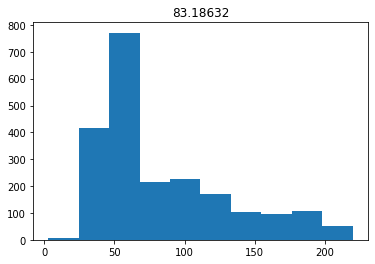

------
===lin1_w===


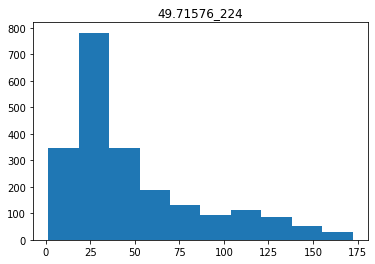

------
37.05102
38.444847
36.156605
36.14464
39.25272
32.958584
[[0.99999964 0.99332774 0.99164253 0.9915987  0.99522185 0.99350953]
 [0.99332774 0.9999998  0.97014743 0.99865484 0.9778356  0.99729943]
 [0.99164253 0.97014743 1.         0.96801627 0.9989259  0.9735506 ]
 [0.9915987  0.99865484 0.96801627 0.9999997  0.9745241  0.99448955]
 [0.99522185 0.9778356  0.9989259  0.9745241  0.9999999  0.98004556]
 [0.99350953 0.99729943 0.9735506  0.99448955 0.98004556 1.0000001 ]]
===lin1_b===


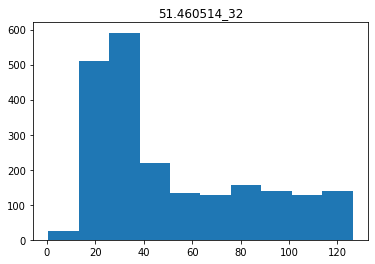

------
43.43861
47.079075
40.188564
42.216503
44.64175
43.396168
[[1.0000001  0.9947572  0.9920246  0.99426246 0.9960754  0.9955933 ]
 [0.9947572  1.0000001  0.9739335  0.99931186 0.98207957 0.99909097]
 [0.9920246  0.9739335  1.0000001  0.9736844  0.9989449  0.97690874]
 [0.99426246 0.99931186 0.9736844  1.         0.9810369  0.99793315]
 [0.9960754  0.98207957 0.9989449  0.9810369  0.99999994 0.98426414]
 [0.9955933  0.99909097 0.97690874 0.99793315 0.98426414 1.0000001 ]]
===lin2_w===


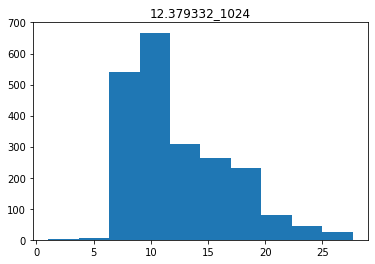

------
7.9426966
8.409628
7.8808627
7.887017
8.265974
7.901252
[[1.         0.9771724  0.97113746 0.98176813 0.98493755 0.974959  ]
 [0.9771724  1.0000004  0.89829564 0.9972439  0.9270873  0.9956464 ]
 [0.97113746 0.89829564 1.         0.91089565 0.996217   0.8986062 ]
 [0.98176813 0.9972439  0.91089565 1.0000004  0.9346962  0.99280524]
 [0.98493755 0.9270873  0.996217   0.9346962  0.99999976 0.92456514]
 [0.974959   0.9956464  0.8986062  0.99280524 0.92456514 1.        ]]
=== lin2_b===


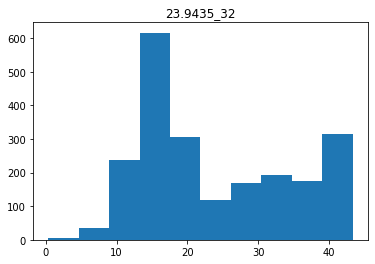

------
20.139444
21.036839
19.697964
19.4334
20.999641
19.688755
[[0.99999994 0.9893134  0.986488   0.9922192  0.99407274 0.9919181 ]
 [0.9893134  0.99999994 0.9520585  0.99955726 0.967703   0.9995535 ]
 [0.986488   0.9520585  1.0000002  0.95865256 0.9983343  0.9580254 ]
 [0.9922192  0.99955726 0.95865256 0.9999999  0.97283745 0.9995637 ]
 [0.99407274 0.967703   0.9983343  0.97283745 0.99999994 0.97242683]
 [0.9919181  0.9995535  0.9580254  0.9995637  0.97242683 1.        ]]
===lin3_w===


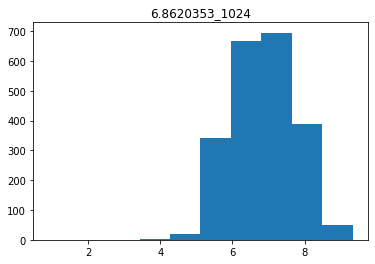

------
4.861181
5.2698555
4.88517
5.1026616
4.9025497
5.1274085
[[1.0000004  0.9617684  0.95046455 0.97150487 0.97228724 0.969697  ]
 [0.9617684  1.         0.8289999  0.99790597 0.8722805  0.99811316]
 [0.95046455 0.8289999  0.99999976 0.85125923 0.9954401  0.84733284]
 [0.97150487 0.99790597 0.85125923 0.9999999  0.8892312  0.9992868 ]
 [0.97228724 0.8722805  0.9954401  0.8892312  0.99999976 0.8860302 ]
 [0.969697   0.99811316 0.84733284 0.9992868  0.8860302  1.0000001 ]]
===lin3_b===


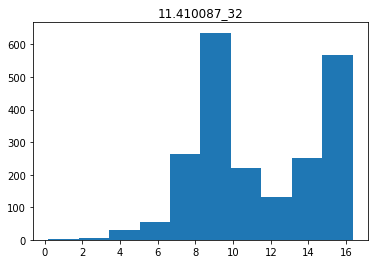

------
9.72122
10.207603
9.497954
9.688874
9.940093
9.666395
[[1.         0.9874057  0.98386836 0.99025637 0.9912774  0.9877989 ]
 [0.9874057  1.0000001  0.943175   0.9997831  0.95797944 0.9997996 ]
 [0.98386836 0.943175   0.9999998  0.9494075  0.9988216  0.9442275 ]
 [0.99025637 0.9997831  0.9494075  0.9999999  0.9632823  0.9996784 ]
 [0.9912774  0.95797944 0.9988216  0.9632823  0.99999994 0.9587373 ]
 [0.9877989  0.9997996  0.9442275  0.9996784  0.9587373  1.        ]]
===lin4_w===


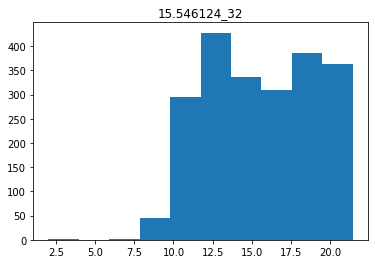

------
11.756355
12.416374
12.428602
12.342884
12.026546
12.330576
[[0.9999999  0.94906855 0.94357145 0.96452814 0.9666325  0.96300745]
 [0.94906855 0.99999994 0.7911733  0.998545   0.8367185  0.9988259 ]
 [0.94357145 0.7911733  1.         0.82271147 0.9968916  0.8194647 ]
 [0.96452814 0.998545   0.82271147 1.         0.8647224  0.9999712 ]
 [0.9666325  0.8367185  0.9968916  0.8647224  0.99999994 0.8618497 ]
 [0.96300745 0.9988259  0.8194647  0.9999712  0.8618497  0.99999994]]
===lin4_b===


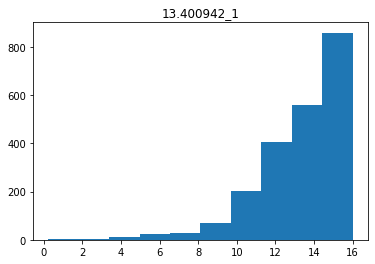

------
13.400942
13.72147
13.063704
13.465234
13.346435
13.444308
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]


In [68]:
corr_grad(wgrad_te4,y_te4,z_te4)
plt.hist(la.norm(wgrad_te4,axis=1))
plt.title(str(np.mean(la.norm(wgrad_te4,axis=1))))
plt.show()
print('-'*6)
for pr in param_names:
    print("="*3+pr+"="*3)
    plt.hist(la.norm(grdic_te4[pr],axis=1))
    plt.title(str(np.mean(la.norm(grdic_te4[pr],axis=1)))+"_"+str(grdic_te4[pr].shape[1]))
    plt.show()
    print("-"*6)
    corr_grad(grdic_te4[pr],y_te4,z_te4)

In [163]:
wgrad_arr = np.array(torch.cat(wgrad_list,dim=0).numpy(),dtype=np.float32)

In [164]:
wmean = np.mean(wgrad_arr,axis=0)
wmean_y0 = np.mean(wgrad_arr[y_arr==0],axis=0)
wmean_y1 = np.mean(wgrad_arr[y_arr==1],axis=0)

wmean_z0 = np.mean(wgrad_arr[z_arr==0],axis=0)
wmean_z1 = np.mean(wgrad_arr[z_arr==1],axis=0)

In [165]:
aa = [wmean,wmean_y0,wmean_y1,wmean_z0,wmean_z1]
for a in aa:
    print(np.linalg.norm(a))

0.13962102
4.8208594
1.0861616
0.21773386
0.09296312


In [170]:
from sklearn.metrics.pairwise import cosine_similarity
aan = np.row_stack(aa)
print(cosine_similarity(aan,aan))

[[ 1.0000001   0.671366   -0.57849014  0.96020055  0.5429791 ]
 [ 0.671366    1.0000004  -0.992907    0.8454311  -0.23911381]
 [-0.57849014 -0.992907    0.9999998  -0.7764525   0.3502759 ]
 [ 0.96020055  0.8454311  -0.7764525   1.0000006   0.2868148 ]
 [ 0.5429791  -0.23911381  0.3502759   0.2868148   0.9999997 ]]


In [71]:
calculate_overall_accuracy(out_tr,y_tr)

0.7364

In [72]:
calculate_overall_accuracy(out_tr[z_tr==0],y_tr[z_tr==0])

0.7331341797361215

In [73]:
calculate_overall_accuracy(out_tr[z_tr==1],y_tr[z_tr==1])

0.7385926792578974

In [132]:
def calculate_overall_accuracy(pred,y):
    pred = pred.flatten()
    return np.sum(pred==y)/len(pred)

In [177]:
gdl_arr = torch.cat(grad_dic['lin4_w'],dim=0).numpy()
print(gdl_arr.shape)

(10000, 32)


In [178]:
lmean = np.mean(gdl_arr,axis=0)
lmean_y0 = np.mean(gdl_arr[y_arr==0],axis=0)
lmean_y1 = np.mean(gdl_arr[y_arr==1],axis=0)

lmean_z0 = np.mean(gdl_arr[z_arr==0],axis=0)
lmean_z1 = np.mean(gdl_arr[z_arr==1],axis=0)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity
aal = [lmean,lmean_y0,lmean_y1,lmean_z0,lmean_z1]
for a in aal:
    print(np.linalg.norm(a))

aanl = np.row_stack(aal)
print(cosine_similarity(aanl,aanl))

0.0093537625
0.5467532
0.12926793
0.016414464
0.010477241
[[ 1.          0.5711562  -0.5087406   0.87814206  0.27278316]
 [ 0.5711562   1.         -0.99724925  0.8935682  -0.63254535]
 [-0.5087406  -0.99724925  1.0000002  -0.85789883  0.68806326]
 [ 0.87814206  0.8935682  -0.85789883  0.99999994 -0.22071445]
 [ 0.27278316 -0.63254535  0.68806326 -0.22071445  1.        ]]


In [182]:
type(grad_dic) == dict

True

In [71]:
y_arr2.shape

(13564,)

## visualize

In [171]:
from sklearn.manifold import TSNE

In [172]:
from sklearn.decomposition import PCA

def viz_plot_grad(grad_list, c_idx = None,method='pca',lywise=False,metric='euclidean',param_names = None):
    if lywise:
        print("lywise")
        assert param_names is not None
        for i, pn in enumerate(param_names):
#             print(grad_list[pn])
            grad_arr = np.array(torch.cat(grad_list[pn],dim=0).numpy(),dtype=np.float32)
            draw_plot(grad_arr,c_idx,method,metric,title=pn)
    else:
        grad_arr = np.array(torch.cat(grad_list,dim=0).numpy(),dtype=np.float32)
#         print(grad_arr.shape)
        draw_plot(grad_arr,c_idx,method,metric)

def draw_plot(grad_arr, c_idx, method,metric = 'euclidean',title =None):
    assert method in ['pca','tsne']
    if method == 'pca':
        grad_emb = PCA(n_components=2,whiten=False).fit_transform(grad_arr)
    else:
        grad_emb = TSNE(n_components=2,learning_rate='auto',init = 'random',metric=metric).fit_transform(grad_arr)
    fig,ax = plt.subplots()
    scatter = ax.scatter(grad_emb[:,0],grad_emb[:,1],c=c_idx)
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    if title is not None:
        plt.title(title)
    plt.show()

In [105]:
len(wgrad_list)

157

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


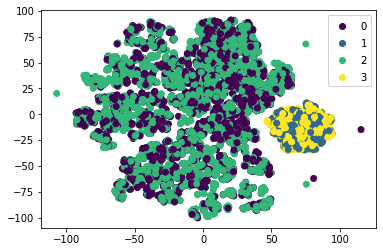

In [111]:
viz_plot_grad(wgrad_list,y_arr+2*z_arr,method='tsne',metric='cosine')

(13564, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


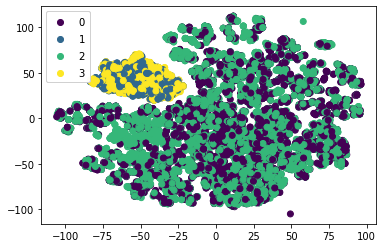

In [112]:
viz_plot_grad(wgrad_list2,y_arr2+2*z_arr2,method='tsne',metric='cosine')

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


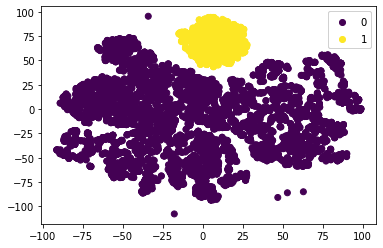

In [109]:
viz_plot_grad(wgrad_list,y_arr,method='tsne',metric='cosine')

(10000, 3617)


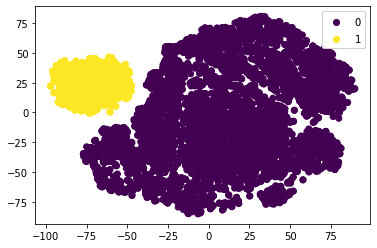

In [107]:
viz_plot_grad(wgrad_list,y_arr,method='tsne')

lywise


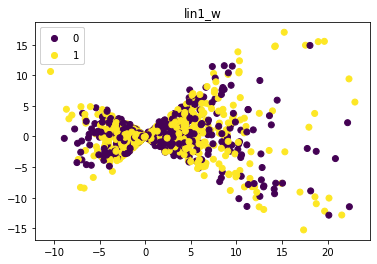

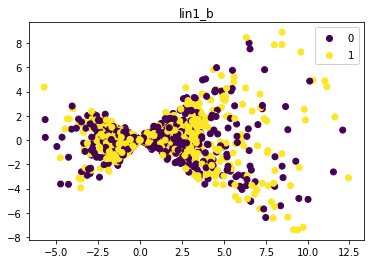

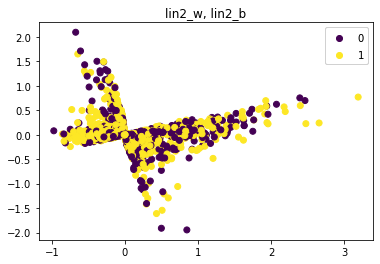

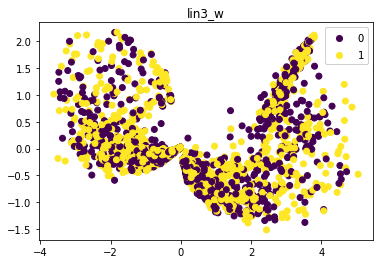

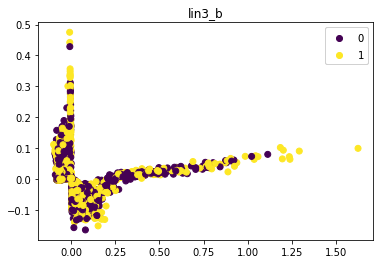

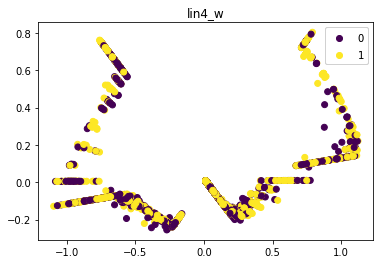

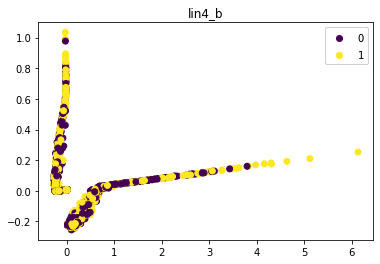

In [95]:
viz_plot_grad(grad_dic,z_arr,lywise=True,param_names =param_names)

lywise


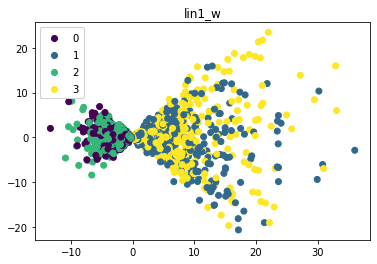

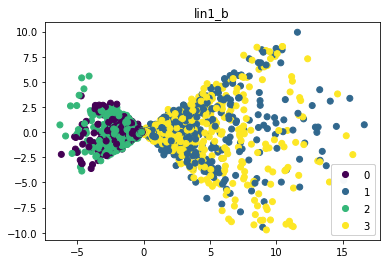

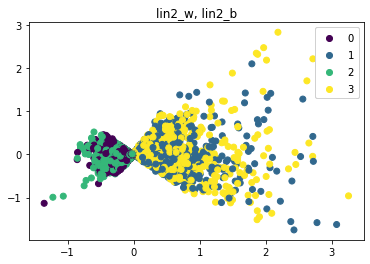

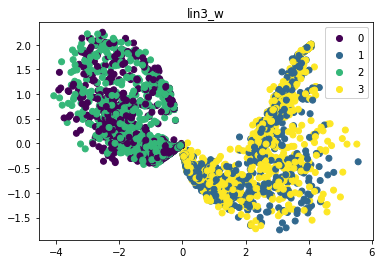

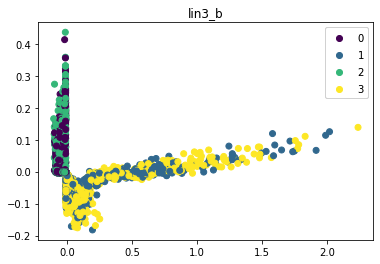

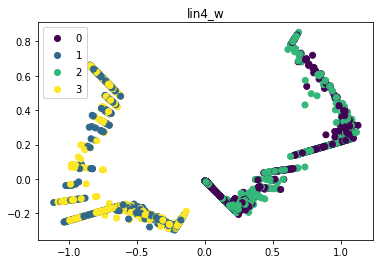

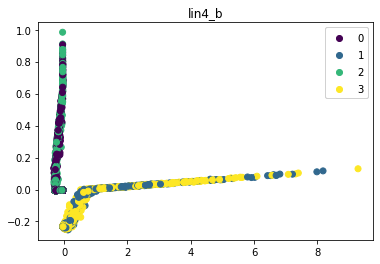

In [113]:
viz_plot_grad(grad_dic2,y_arr2+2*z_arr2,lywise=True,param_names =param_names)

lywise


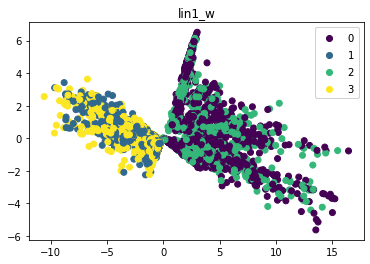

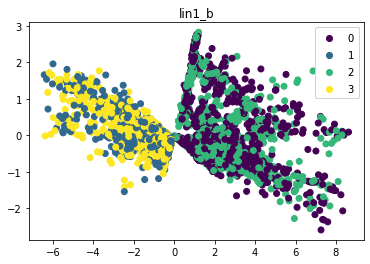

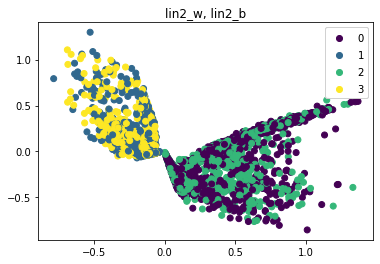

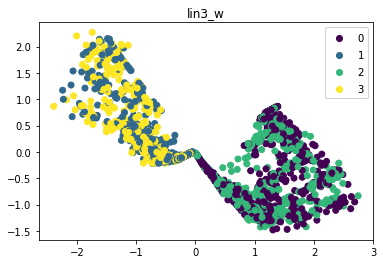

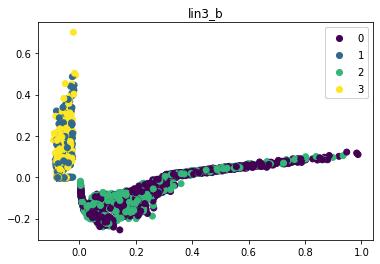

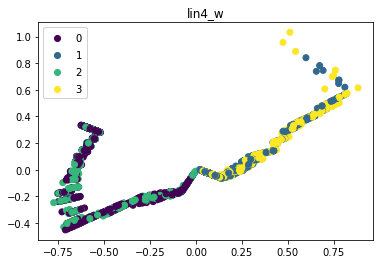

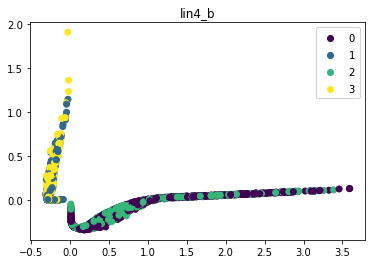

In [174]:
viz_plot_grad(grad_dic,y_arr+2*z_arr,lywise=True,param_names =param_names)